In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import os
import json
import base64
import io
import re

# Decode image bytes to pillow array
def img_data_to_arr(img_data):
    f = io.BytesIO()
    f.write(img_data)
    img_arr = Image.open(f)
    return img_arr

# Decode base64 image to pillow array
def img_b64_to_arr(img_b64):
    img_data = base64.b64decode(img_b64)
    img_arr = img_data_to_arr(img_data)
    return img_arr

# Search for an img file in the directory
def getImgPath(name,data_dir):

    test_name = ".".join(name.split(".")[:-1])

    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if test_name in file and "json" not in file:
                return os.path.join(root,file)
    return None

# Shuffle n lists in unison
def unison_shuffled_copies(a, *argv):
    for arg in argv:
        assert len(a) == len(arg)

    p = np.random.permutation(len(a))

    out = [a[p]]+[arg[p] for arg in argv]

    return out

"""
Crops an annotation based on coordinates in the original image

Inputs
    image       Base image to crop annotation from
    polygon     Polygon consisting of coordinates saved in a list

Returns
    Cropped annotation in npy format
"""
def cropAnnotation(image,polygon):
    imArray = np.asarray(image)
    try:
        if len(imArray.shape)==2:
            imArray = np.transpose([imArray,imArray,imArray],[1,2,0])
        elif len(imArray.shape)==3:
            imArray = imArray[:,:,:3]
    except ValueError:
        print(imArray.shape)
        raise
    # create mask
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    newImArray = np.empty(imArray.shape,dtype='uint8')

    # colors (three first columns, RGB)
    newImArray[:,:,:3] = imArray[:,:,:3]

    # transparency (4th column)
    newImArray = newImArray*np.transpose([mask,mask,mask],[1,2,0])

    xmin = np.min(np.array(polygon)[:,0])
    xmax = np.max(np.array(polygon)[:,0])
    ymin = np.min(np.array(polygon)[:,1])
    ymax = np.max(np.array(polygon)[:,1])

    return newImArray[int(ymin):int(ymax)+1,int(xmin):int(xmax)+1]

# Resize image stored in npy by using pillow
def resizeNumpy(arr,size=(224,224)):
    im = Image.fromarray(arr)
    im = im.resize(size)
    return np.array(im)

# Get ID from file name by scanning for int values
def getID(name):
    for idx,i in enumerate(name):
        try:
            int(i)
        except ValueError:
            return int(name[:idx])
            break


"""
Deletes an image from the ids dict and updates accordingly

Inputs
    img_ids     IDs of images to delete from dict
    ids         Nested dict containing the painter-image relations

Returns
    ids         Updated nested dict
"""
def updateIds(img_ids,ids):
    for img_id in img_ids:

        toPop = []

        # Find image id in the dict and remove it
        for key,value in ids.items():
            for key2,value2 in value.items():
                if img_id in value2:
                    value2.remove(img_id)

                if len(value2)==0:
                    toPop.append((key,key2))

        # Update index for all following images
        for key,value in ids.items():
            for key2,value2 in value.items():
                for v in range(len(value2)):
                    if value2[v]>img_id:
                        value2[v]-=1

        # Remove full images if all parts are deleted
        for key,key2 in toPop:
            print("Removed",key,key2)
            ids[key].pop(key2)


    return ids

"""
Loads the Egraphsen image data from the raw directory containing jsons

Inputs
    classes     Annotation labels to load. Loads all if equal None
    data_dir    Directory to extract data from
    painters    List of painters to extract data for. Name must match the subfolder name
    load        Boolean whether to load the data from the raw folder or from saved dataset
    save        Boolean whether to save dataset after processing
    load_dir    Directory to load the dataset from
    save_dir    Directory to save the dataset to
    load_crops  Boolean whether to load the annotations as well
    img_size    Size of the images after resizing

Returns
    images          Images in numpy array
    labels          Labels in numpy array
    crops           Annotation crops in numpy array
    crop_labels     Labels of Annotation crops in numpy array
    ids             Nested dict containing the painter image relation
"""
def loadData(classes= ["foot","ear","eyebrow","hand","eye","mouth","arm","nose""hair","head"],
             data_dir = "/Users/souayboubagayoko/Desktop/Musium/egraphsen-tool-local/painter",
             painters = ['Makron', 'Achilles', 'Douris', 'Oltos', 'Phiale', 'Meleager', 'Niobid', 'Brygos', 'Meidias', 'Berlin'],

             load = False,
             save = False,
             load_dir="./",
             save_dir="./",
             load_crops=True,
             img_size = (224,224)
            ):

    ids = {}
    images = []
    labels = []
    crops = []
    crop_labels = []
    cur_idx = 0
    jsons = []

    if load and os.path.exists(os.path.join(load_dir,"images.npy")):
        print(f"Loading data from {load_dir}")

        if load:
            images = np.load(os.path.join(load_dir,"images.npy"))
            labels = np.load(os.path.join(load_dir,"labels.npy"))
            ids = np.load(os.path.join(load_dir,"ids.npy"),allow_pickle=True).item()

            if load_crops:
                crops = np.load(os.path.join(load_dir,"crops.npy"),allow_pickle=True)
                crop_labels = np.load(os.path.join(load_dir,"crop_labels.npy"),allow_pickle=True)

                if classes is not None:

                    # Select the subset of annotations w.r.t. the selected classes
                    new_crop_labels = []
                    new_crops = []
                    remove = []

                    for c_id,crop_list in enumerate(crop_labels):
                        new_idx = [idx for idx,c in enumerate(crop_list) if c in classes]

                        # Save img ids that have no objects of this class
                        if len(new_idx)==0:
                            remove.append(c_id)
                            continue

                        new_crop_labels.append(np.array(crop_list)[new_idx])
                        new_crops.append([crop for idx,crop in enumerate(crops[c_id]) if idx in new_idx])

                    images      = np.delete(images,remove,0)
                    labels      = np.delete(labels,remove,0)
                    crop_labels = new_crop_labels
                    crops       = new_crops
                    ids         = updateIds(remove,ids)

            else:
                crops = None
                crop_labels = None




    else:
        try:
            if load == True:
                print(f"Save files not found in {load_dir}.")
            print("Extracting images...")

            shapes = []

            for pid,painter in enumerate(painters):
                ids[(pid,painter)] = {}
                print(f"... from {painter}")
                print(" testing ")

                for folder in os.listdir(os.path.join(data_dir,painter)):
                    if folder.startswith('.'):
                        print(folder)
                        continue
                    cur_path  = os.path.join(data_dir,painter,folder)
                    cur_jsons = [js for js in os.listdir(cur_path) if ".json" in js]

                    for idx,js in enumerate(cur_jsons):

                        if idx%10==0:
                            print(f"{idx}/{len(cur_jsons)}")

                        if js in ["7242B-Buitron-Oliver(1995)Taf59_cut_PTRDouris_MM_14102020.json",
                                  "7242A-Buitron-Oliver(1995)Taf59_cut_PTRDouris_MM_11102020.json"]:
                            continue

                        try:
                            img,annos,crop_set = loadJSON(cur_path,js,classes,data_dir,img_size=img_size)
                        except:
                            continue

                        shapes.append(np.array(img).shape)

                        img = np.array(img.resize(img_size))

                        if len(img.shape)==3:
                            img = img[:,:,0]

                        images.append(img)
                        jsons.append(js)

                        img_id = getID(js)

                        if img_id not in ids[(pid,painter)].keys():

                            ids[(pid,painter)][img_id] = [cur_idx]
                        else:
                            ids[(pid,painter)][img_id].append(cur_idx)

                        cur_idx+=1
                        labels.append(pid)

                        crops.append(crop_set)
                        crop_labels.append([a[0] for a in annos])

            if save:
                try:
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)

                    np.save(os.path.join(save_dir,"images.npy"),images)
                    np.save(os.path.join(save_dir,"labels.npy"),labels)
                    np.save(os.path.join(save_dir,"crops.npy"),crops)
                    np.save(os.path.join(save_dir,"crop_labels.npy"),crop_labels)
                    np.save(os.path.join(save_dir,"ids.npy"),ids)

                except Exception as e:
                    print("Saving failed",e)


        except KeyboardInterrupt :
            return None,None,None,None,ids,None

    # Normalize images to mean 0 and std 1
    images = np.array(images)
    images = images-images.mean()
    images = images/images.std()
    images = np.expand_dims(images,-1)


    return images,labels,crops,crop_labels,ids,jsons

def circleToPoly(points,num_points=16):
    center,out = points

    deg = [i*(360./num_points) for i in range(num_points)]
    r = np.sqrt((center[0]-out[0])**2+(center[1]-out[1])**2)

    points = []
    for point in deg:
        X = center[0] + (r * np.cos(np.radians(point)))
        Y = center[1] + (r * np.sin(np.radians(point)))
        points.append([X,Y])

    return points

def loadPolygons(shapes,classes = None):

    annos = []

    for shape in shapes:

        if classes is not None and shape["label"] not in classes:
            continue

        if shape["shape_type"] == "polygon":
            annos.append((shape["label"],[tuple(l) for l in shape["points"]]))

        elif shape["shape_type"] == "circle":
            annos.append((shape["label"],[tuple(l) for l in circleToPoly(shape["points"])]))

        else:
            raise ValueError("Unrecognized Annotation Shape",shape["shape_type"])

    return annos

"""
Function that takes in a json and tries to load the image and metadata

Inputs
    path:       Directory that contains json
    js          json File name
    classes     Annotation labels to load. Loads all if equal None
    data_dir    Directory to check for the raw image in case it is not encoded in the json

Returns
    img         Image data in numpy format
    annos       List of annotations labels and coordinates
    crop_set    List of annotations in image form as numpy array
"""
def loadJSON(path,js,classes,data_dir,img_size):

    # Decode json to python dict
    try:
        data = json.load(open(os.path.join(path,js)))
    except UnicodeDecodeError:
        data = json.load(open(os.path.join(path,js), encoding="latin-1"))

    # Try to load image data from json
    imageData = data.get('imageData')

    # If image not encoded in json, try to load image from data_dir
    if not imageData:
        imagePath = data.get('imagePath')

        if "\\" in imagePath:
            img = imagePath.split("\\")[-1]
        else:
            img = imagePath.split("/")[-1]

        img_path = getImgPath(img,data_dir)
        if img_path is None:
            print("Does not exist!!!")
            print(path,js)
            return None



    else:
        img = img_b64_to_arr(imageData)

    # Load annotations and crop image w.r.t. them
    #if classes is not None:
        #annos = [(x["label"],[tuple(l) for l in x["points"]]) for x in data["shapes"] if x["label"] in classes]
    #else:
        #annos = [(x["label"],[tuple(l) for l in x["points"]]) for x in data["shapes"]]
    annos = loadPolygons(data["shapes"],classes)
    crop_set = [resizeNumpy(cropAnnotation(img,polygon[1])[:,:,0],img_size) for polygon in annos]

    return img,annos,crop_set

"""
Make k-fold split per painter while guaranteeing that all images belonging to the same vase are in the same fold

Inputs
    ids:        Nested dictionary generated by loadData which contains the image hierarchy
    num_folds   Number of cross validation folds
    load        Whether to load the splits from load_dir
    save        Boolean whether to save the splits in save_dir

Returns
    folds       Returns a list of the folds. Each fold consists of 3 lists containing the respective indexes
"""
def k_fold_split(ids,
                 num_folds = 10,
                 load = False,
                 save = False,
                 load_dir="./",
                 save_dir="./"):

    if load:
        if os.path.exists(os.path.join(load_dir,"folds.npy")):
            print("Loaded folds succesfully")
            return np.load(os.path.join(load_dir,"folds.npy"),allow_pickle=True)
        else:
            print("Saved folds not found in {load_dir}")

    all_ids = []

    folds_per_painter = []
    for painter in range(len(ids.keys())):

        p_id    = list(ids.keys())[painter]
        new_ids = list(ids[p_id].values())
        np.random.shuffle(new_ids)

        tmp_list = [item for sublist in new_ids for item in sublist]
        all_ids.append(tmp_list)
        tmp_list = np.array_split(tmp_list,num_folds)
        tmp_list = [list(t) for t in tmp_list]


        cur_fold = 0
        cur_vase = 0

        for l in tmp_list:
            if len(l)==0:
                print(painter)
                raise ValueError("HUH")

        while cur_vase < len(new_ids):
            if set(new_ids[cur_vase]).issubset(set(tmp_list[cur_fold])): # all parts of vase cur_id are contained in fold cur_list
                cur_vase   += 1

            elif len(np.intersect1d(new_ids[cur_vase],tmp_list[cur_fold])) == 0: # no parts of vase cur_id are contained in fold cur_list
                cur_fold += 1

            else:
                missing = np.setdiff1d(new_ids[cur_vase],tmp_list[cur_fold]) # parts of vase cur_id are contained in multiple folds
                tmp_list[cur_fold] += list(missing) # Add missing parts to fold cur_list
                for img in missing:
                    tmp_list[cur_fold+1].remove(img)

                cur_fold += 1
                cur_vase += 1

            if np.min([len(t) for t in tmp_list])==0:
                tmp_list.remove([])

        assert set([t[-1] for t in tmp_list]).issubset(set([t[-1] for t in new_ids])) # check whether all parts of a vase are contained within a single fold

        if len(tmp_list) < num_folds:
            print(f"Painter {p_id} has {len(tmp_list)} folds")
            while len(tmp_list) < num_folds:
                tmp_list.append([])
                #tmp_list.append(tmp_list[np.random.randint(len(tmp_list))])

        folds_per_painter.append(tmp_list)

    # Concatenating folds between painters
    folds = []
    all_ids = np.concatenate(all_ids)

    for f in range(num_folds):

        test  = np.concatenate([p_fold[f] for p_fold in folds_per_painter]).astype(int)
        train = np.setdiff1d(all_ids,test)

        folds.append((train,test))

        assert len(train)+len(test) == len(all_ids)

    if save:
        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            np.save(os.path.join(save_dir,"folds.npy"),folds)

        except Exception as e:
            print("Saving failed",e)

    return folds


In [73]:
import matplotlib.pyplot as plt
import cv2
import PIL
import numpy as np
from PIL import Image
import os 
import shutil
import json
from IPython.display import display
import tensorflow as tf
from pathlib import Path, fnmatch
from IPython.core.debugger import set_trace
%matplotlib inline


In [7]:
!pwd

/Users/souaybGA_1/Desktop/egraphsen-tool-local


In [259]:
def resizeNumpy(arr,size=(512,512)):
    if isinstance(arr, np.ndarray): 
        im = Image.fromarray(arr)
    else :
        im = arr
    im = im.resize(size)
    return im
            
def get_poly(poly_path):
    try :
        
        with open(poly_path) as jsonfile:
            poly_dicts= json.load(jsonfile)
    except UnicodeDecodeError:
        with open(poly_path, encoding='latin-1') as jsonfile:
            poly_dicts= json.load(jsonfile)
    return poly_dicts['shapes']

def read_image(path, fromcv:str=True):
    if fromcv:
        return cv2.imread(path, 0)
    else :
        image = PIL.Image.open(path)
        return np.array(image)


def create_mask(inputpath, dst:str):
    dirlists = os.listdir(inputpath)
    
    for inpath in dirlists:
        currentdir = os.path.join(inputpath, inpath)
        if not os.path.isdir(currentdir):
            continue
        filelists   = [ file for file in os.listdir(currentdir) if file.endswith(('.jpg', '.jpeg', '.tif','.gif', '.png'))]
        if not filelists :
            continue
#         class_lists = ['arm', 'head','foot']
        class_lists = ['head']
        if not os.path.isdir(dst):
            Path(dst).mkdir(parents=True, exist_ok=True)

        if not os.path.isdir(os.path.join(dst, 'img')):
            os.mkdir(os.path.join(dst, 'img'))
            os.mkdir(os.path.join(dst, 'annot'))
        for file in filelists:

            stemname = Path(file).stem
            #readin the image 
            impath = os.path.join(currentdir, file)
            img = read_image(impath)
            #reading the poygone

            polypath = os.path.join(currentdir, stemname+'.json')
            if not Path(polypath).exists():
                continue
            poly = get_poly(polypath)
            # getting the file 
            mask = np.zeros(shape= (img.shape[0],img.shape[1]), dtype=np.float32)
            for shape in poly:
                if shape['label'] in class_lists:
                    points = np.array(shape['points'], dtype=np.int32)
                    cv2.fillPoly(mask, [points], 255)
            #set_trace()
            mask = PIL.Image.fromarray(mask)
            mask  = mask.convert("L")
            img = resizeNumpy(img)
            mask= resizeNumpy(mask)
            img.save(os.path.join(dst,'img', stemname+'.png'))
            mask.save(os.path.join(dst,'annot', stemname+'.png'))



In [163]:
testpath = "/Users/souaybGA_1/Desktop/egraphsen-tool-local/painter/Phiale/"

In [260]:
create_mask(testpath, dst="/Users/souaybGA_1/Desktop/egraphsen-tool-local/painter/newannot")

['.DS_Store',
 '[Achilles] Vermutend zugewiesen',
 'AchillesEindeutig_zugewiesen']

In [4]:
def get_poly(poly_path):
    with open(poly_path) as jsonfile:
        poly_dicts= json.load(jsonfile)
    return poly_dicts['shapes']

def read_image(path, fromcv:str=True):
    if fromcv:
        return cv2.imread(path, 0)
    else :
        image = PIL.Image.open(path)
        return np.array(image)

def creat_annot(path, pattern:str='*.json'):
    if not Path(path).is_dir:
        raise Exception("the source file need to be a directory")
    trainpath = os.path.join(path, 'train')
    testpath  = os.path.join(path, 'test')
    trainfiles = fnmatch.filter(os.listdir(trainpath), pattern)
    testfiles  = fnmatch.filter(os.listdir(testpath), pattern)
    if not os.path.isdir(os.path.join(path, 'train','annot')):
        os.mkdir(os.path.join(path, 'train','annot'))
        os.mkdir(os.path.join(path, 'test','annot'))
    if not os.path.isdir(path):
        Path(path).mkdir(parents=True, exist_ok=True)
    for file in trainfiles:
        stemname = Path(file).stem
        trainname = stemname+'.png'
        img = read_image(os.path.join(trainpath, trainname), False)
        poly = get_poly(os.path.join(trainpath, file))
        mask = get_mask(img, poly)
        mask = PIL.Image.fromarray(mask)
        mask  = mask.convert("L")
        mask.save(os.path.join(trainpath,'annot', stemname+'.png'))

    for file in testfiles:
        stemname = Path(file).stem
        testname = stemname+'.png'
        img = read_image(os.path.join(testpath, testname), False)
        poly = get_poly(os.path.join(testpath, file))
        mask = get_mask(img, poly)
        mask = PIL.Image.fromarray(mask)
        mask  = mask.convert("L")
        mask.save(os.path.join(testpath,'annot', stemname+'.png'))


In [165]:
def move_file(src: str, dst: str,
              pattern: str = '*.json',
              test_size= 0.15
             ):
    if not Path(src).is_dir:
        raise Exception("the source file need to be a directory")

    listfiles  = fnmatch.filter(os.listdir(src), pattern)
    test_number  = int(len(listfiles)*test_size)
    trainfiles, trestfiles = listfiles[test_number:], listfiles[:test_number]
    if not os.path.isdir(dst):
        Path(dst).mkdir(parents=True, exist_ok=True)
    
    if not os.path.isdir(os.path.join(dst, 'train')):
        os.mkdir(os.path.join(dst, 'train'))
        os.mkdir(os.path.join(dst, 'test'))
    for train in trainfiles:
        trainname = Path(train).stem+'.png'

        shutil.move(os.path.join(src, train), os.path.join(dst, 'train',train))
        shutil.move(os.path.join(src, trainname), os.path.join(dst,'train',trainname))
    for test in listfiles:
        testname = Path(test).stem+'.png'
        shutil.move(os.path.join(src, test), os.path.join(dst,'test',test))
        shutil.move(os.path.join(src, testname), os.path.join(dst,'test', testname))


In [ ]:
def move_fl(src: str, dst: str,
              pattern: str = '*.json',
              test_size= 0.15
             ):
    if not Path(src).is_dir:
        raise Exception("the source file need to be a directory")

    listfiles  = fnmatch.filter(os.listdir(src), pattern)
    test_number  = int(len(listfiles)*test_size)
    trainfiles, trestfiles = listfiles[test_number:], listfiles[:test_number]
    if not os.path.isdir(dst):
        Path(dst).mkdir(parents=True, exist_ok=True)
    
    if not os.path.isdir(os.path.join(dst, 'train')):
        os.mkdir(os.path.join(dst, 'train'))
        os.mkdir(os.path.join(dst, 'test'))
    for train in trainfiles:
        trainname = Path(train).stem+'.png'

        shutil.move(os.path.join(src, train), os.path.join(dst, 'train',train))
        shutil.move(os.path.join(src, trainname), os.path.join(dst,'train',trainname))
    for test in listfiles:
        testname = Path(test).stem+'.png'
        shutil.move(os.path.join(src, test), os.path.join(dst,'test',test))
        shutil.move(os.path.join(src, testname), os.path.join(dst,'test', testname))


In [170]:
import pixellib
from pixellib.semantic import semantic_segmentation
import cv2

segment_image = semantic_segmentation()
segment_image.load_pascalvoc_model("/Users/souaybGA_1/Downloads/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")
segvalues, output = segment_image.segmentAsPascalvoc("/Users/souaybGA_1/Desktop/egraphsen-tool-local/painter/Brygos/[Brygos] Vermutend zugewiesen/203934I-9069_PTRBrygos_ML_24022021.jpg")
cv2.imwrite("img.jpg", output)
print(output.shape)

2021-12-05 17:08:07.317266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


(1280, 1280, 3)


In [3]:
impat = "/Users/souaybGA_1/Desktop/egraphsen-tool-local/painter/Brygos/[Brygos] Vermutend zugewiesen/203934I-9069_PTRBrygos_ML_24022021.jpg"
img = cv2.imread(impat)

In [366]:
im_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [344]:
# ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 3, cv2.LINE_AA)
cv2.imshow('SIMPLE Approximation contours', image_copy)
cv2.imshow("grey", gray)
cv2.waitKey(0)
# 12
# image_copy3 = image1.copy()
# 13
# for i, contour in enumerate(contours2): # loop over one contour area
# 14
#    for j, contour_point in enumerate(contour): # loop over the points
# 15
#        # draw a circle on the current contour coordinate
# 16
#        cv2.circle(image_copy3, ((contour_point[0][0], contour_point[0][1])), 2, (0, 255, 0), 2, cv2.LINE_AA)
# 17
# # see the results
# 18
# cv2.imshow('CHAIN_APPROX_SIMPLE Point only', image_copy3)
# 19
# cv2.waitKey(0)
# 20
# cv2.imwrite('contour_point_simple.jpg', image_copy3)


113

2.0


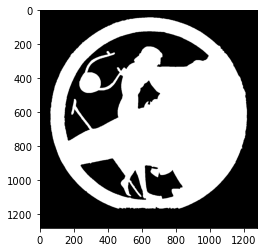

In [57]:
blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
ret, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_TRIANGLE)
print(ret)
plt
plt.imshow(threshold, cmap='gray')

75.0


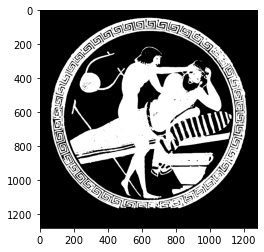

In [56]:
blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
ret, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)#cv2.THRESH_BINARY+ cv2.THRESH_TRIANGLE)
print(ret)
plt
plt.imshow(threshold, cmap='gray')

83.0


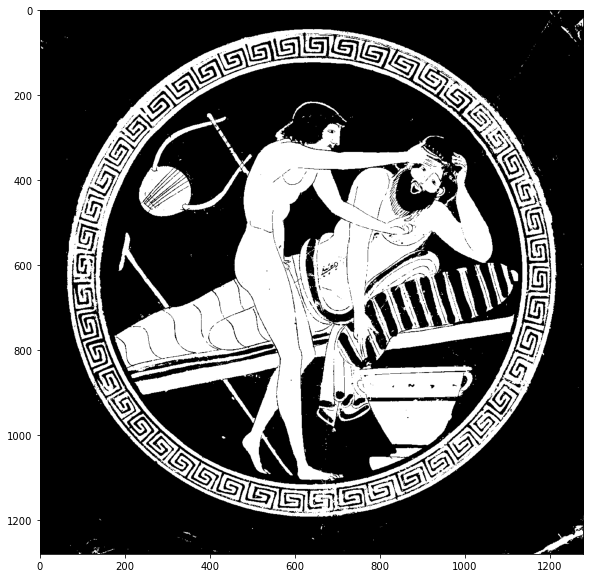

In [342]:
ret, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
print(ret)
plt.imshow(threshold, cmap='gray')
np.max(threshold)
tosave = PIL.Image.fromarray(threshold)
tosave.save("Fazzu_test.png")

In [251]:
!pwd

/Users/souaybGA_1/Desktop/egraphsen-tool-local


In [ ]:
from skimage import morphology, segmentation


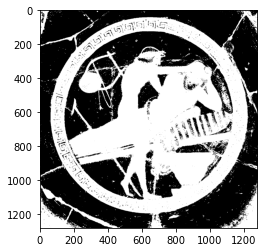

In [178]:
plt.imshow(threshold, cmap='gre)

In [471]:
h, w = img.shape[:2]
print(h)

1280


In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
from skimage import measure
# img = cv2.imread(impat)
# new_imag = img.copy()

img = cv2.imread('/Users/souaybGA_1/Desktop/tt.png')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (0,0,img.shape[0],img.shape[1])

height, width, _ = img.shape
left_margin_proportion = 0.01
right_margin_proportion = 0.01
up_margin_proportion = 0.01
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)


# boundary_rectangle = (
#     int(width  ),
#     int(height  ),
#     int(width),
#     int(height),
# )


cv2.grabCut(img,mask,boundary_rectangle,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)
# ret, thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_TRIANGLE)

# ######### Testing ###########
# gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binarized_image = cv2.adaptiveThreshold(
    img_gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)

# # Initialize the mask with known information
 
# mask[:] = cv2.GC_PR_BGD
# mask[binarized_image == 0] = cv2.GC_FGD




edged = cv2.Canny(thresh, 30, 200)
edged1 = cv2.Canny(binarized_image, 30, 200)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours1, hierarchy1 = cv2.findContours(edged1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contt = measure.find_contours(thresh, 0.5, positive_orientation='low')
print('contt111', type(contt), len(contt))
print('contt', type(contours),  contours)
image_copy = img.copy()
image_copy1 = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 3, cv2.LINE_AA)
 
cv2.drawContours(image_copy1, contt[0].astype(np.int32), -1, (0, 255, 0), 3, cv2.LINE_AA)
cv2.imshow('SIMPLE Approximation contours', image_copy)
cv2.imshow('SIMPLE Approximation contours1', image_copy1)

cv2.imshow("edge", edged)
cv2.imshow("binary", binarized_image)
cv2.imshow('edge1',edged1)
cv2.imshow("thresh", thresh)
cv2.waitKey(0)
# plt.rcParams['figure.figsize'] = (20, 10)
# plt.imshow(img)
# # plt.colorbar()
# plt.show()

contt111 <class 'list'> 1
contt <class 'tuple'> (array([[[ 75,   3]],

       [[ 73,   5]],

       [[ 70,   5]],

       [[ 66,   9]],

       [[ 65,   9]],

       [[ 57,  17]],

       [[ 57,  18]],

       [[ 55,  20]],

       [[ 55,  21]],

       [[ 53,  23]],

       [[ 53,  25]],

       [[ 51,  27]],

       [[ 51,  31]],

       [[ 45,  37]],

       [[ 44,  37]],

       [[ 43,  38]],

       [[ 43,  41]],

       [[ 41,  43]],

       [[ 41,  45]],

       [[ 37,  49]],

       [[ 36,  49]],

       [[ 31,  54]],

       [[ 31,  56]],

       [[ 32,  56]],

       [[ 33,  57]],

       [[ 33,  59]],

       [[ 31,  61]],

       [[ 29,  61]],

       [[ 29,  64]],

       [[ 28,  65]],

       [[ 28,  68]],

       [[ 30,  70]],

       [[ 32,  70]],

       [[ 33,  71]],

       [[ 33,  77]],

       [[ 34,  78]],

       [[ 43,  78]],

       [[ 46,  81]],

       [[ 46,  83]],

       [[ 49,  86]],

       [[ 54,  86]],

       [[ 56,  88]],

       [[ 65,  88]],

     

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/drawing.cpp:2501: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
# img = cv2.imread(impat)
img = cv2.imread('/Users/souaybGA_1/Desktop/tt.png')


x,y, w, h = rect = (700,400,850,500)
contour, painted = grab_cat_mask(img, rect=rect) 
 
cv2.imshow("ouput", painted)
cv2.waitKey(0)
 

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/core/src/matrix.cpp:811: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in function 'Mat'


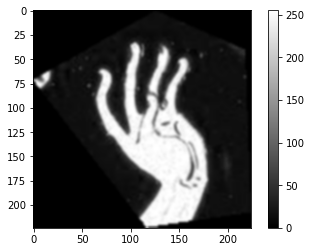

(<matplotlib.image.AxesImage at 0x7f7c2e9e9880>,
 None)

In [63]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("/Users/souaybGA_1/Downloads/1007_hand.png")
mask = np.zeros(img.shape[:2],np.uint8)
# mask = np.zeros(shape=img.shape[:2],np.uint8) # zeroes as array/matrix size of image
bgdModel = fgdModel = np.zeros((1,65),np.float64)    

newmask = cv2.imread("/Users/souaybGA_1/Downloads/1007_hand.png",0)
 
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
# ret, thresh = cv2.threshold(img_gray, 0, 100, cv2.THRESH_BINARY+ cv2.THRE)
edged = cv2.Canny(thresh,100, 200)
# edged = cv2.Canny(thresh,1500, 1000)
plt.imshow(blurred, cmap='gray'),plt.colorbar(),plt.show()


image shape (224, 224, 3)


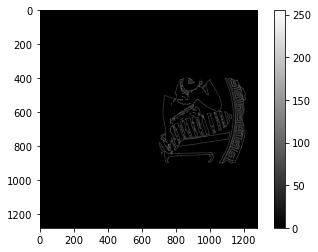

(<matplotlib.image.AxesImage at 0x7f7c2ad562e0>,
 None)

In [36]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("/Users/souaybGA_1/Downloads/1007_hand.png")
print("image shape", img.shape)
mask = np.zeros(img.shape[:2],np.uint8)
# mask = np.zeros(shape=img.shape[:2],np.uint8) # zeroes as array/matrix size of image
bgdModel = fgdModel = np.zeros((1,65),np.float64)    

newmask = cv2.imread("/Users/souaybGA_1/Downloads/1007_hand.png",0)

# informational purposes
removeBg = (newmask == 0)
removeBg = np.ravel(removeBg)
np.bincount(removeBg)
keepFg = (newmask == 255)
keepFg = np.ravel(keepFg)
np.bincount(keepFg)


mask = np.where(((newmask>0) & (newmask<255)),cv2.GC_PR_FGD,0).astype('uint8')
mask[newmask == 0] = cv2.GC_BGD
mask[newmask == 255] = cv2.GC_FGD
#otherEl = (not (newmask == 0 or newmask == 255)) # throws error
#otherEl = np.ravel(otherEl)
#np.bincount(otherEl)
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)


binarized_image = cv2.adaptiveThreshold(
    img_gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)
# ret, thresh = cv2.threshold(img_gray, 0, 100, cv2.THRESH_BINARY+ cv2.THRESH_TRIANGLE)
# # appears at least one of each elements is required
# # otherwise throws bgdSamples.empty error / fgdSamples.empty error
# mask[newmask == 0] = 0
# mask[newmask == 255] = 1

# mask, bgdModel, fgdModel = cv2.grabCut(thresh,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)


# # mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# img2 = img*mask2[:,:,np.newaxis]
 
# edged = cv2.Canny(binarized_image+thresh[:,:,np.newaxis],10, 100)
# edged = cv2.Canny(edged,1500, 1000)
edged = cv2.Canny(thresh,1500, 1000)
plt.imshow(edged, cmap='gray'),plt.colorbar(),plt.show()

In [31]:
import PIL
from PIL import Image, ImageOps, ImageStat
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

def is_grayscale(arr):

    im = Image.fromarray(arr)
    stat = ImageStat.Stat(im)

    if sum(stat.sum)/3 == stat.sum[0]:
        return True
    else:
        return False

In [29]:
import time 
# ii = '/Users/souaybGA_1/Downloads/tt.png'
ii = '/Users/souaybGA_1/Desktop/tt.png'
%time is_grey_scale(ii)

CPU times: user 2.73 ms, sys: 1.44 ms, total: 4.17 ms
Wall time: 2.87 ms


False

In [34]:
hh= cv2.imread("/Users/souaybGA_1/Downloads/1007_hand.png")
type(img)

numpy.ndarray

In [35]:
%time is_grayscale(hh)

CPU times: user 925 µs, sys: 642 µs, total: 1.57 ms
Wall time: 955 µs


True

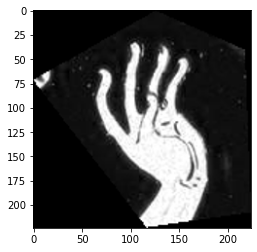

In [10]:
plt.imshow(img)

In [37]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
# img = cv2.imread(impat)
img = cv2.imread('/Users/souaybGA_1/Desktop/tt.png')
# img = cv2.imread("/Users/souaybGA_1/Downloads/1007_hand.png")

rect = None#(700,400,850,500)
contour, painted = grab_cat_mask(img, rect=rect, apply_blur=True) 
 
cv2.imshow("ouput", painted)
cv2.waitKey(0)

113

In [34]:
import cv2
import numpy as np 
from PIL  import Image, ImageStat

import traceback

def bad_method():
    try:
        sqrt = 0**-1
    except Exception:
        print(traceback.print_exc())


def is_grayscale(arr):
    im = Image.fromarray(arr)
    stat = ImageStat.Stat(im)

    if sum(stat.sum)/3 == stat.sum[0]:
        return True
    else:
        return False

def grab_cat_mask(image, rect:list=None, 
                  plot_contour:bool=True, 
                  finegrain_contour:bool=False, 
                  apply_blur:bool=True):
    """
    Input:
        image: type= numpy array
        rect:(default=None) the focus box for grabcut if None the entire image is used
        plot_contour
    Ouptut:
        contour:list of all the contours 
        mask 
    """
    assert isinstance(image, np.ndarray), 'image must be a numpy array'
    
    image_copy = image.copy()
    if is_grayscale(image):
        
        if rect:
            thresh = np.zeros(img.shape[:2],np.uint8)
            x,y, w, h = rect
            crop = image[y:y+h, x:x+w]
            
            try:
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            except Exception as e:
                raise ValueError("PLease very that the rectangle coordinate is correct")

            if apply_blur:
                 crop =  cv2.GaussianBlur(crop, (3, 3), 0)
            ret, threshold = cv2.threshold(crop, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
            
            thresh[y:y+h, x:x+w] = threshold
        else:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            if apply_blur:
                 img_gray =  cv2.GaussianBlur(img_gray, (3, 3), 0)
            ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
        
    else:
        height, width  = image.shape[:2]
        mask = np.zeros((height, width),np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)

        left_margin_proportion = 0.01
        right_margin_proportion = 0.01
        up_margin_proportion = 0.01
        down_margin_proportion = 0.01

        if not rect:
            rect = (
                int(width * left_margin_proportion),
                int(height * up_margin_proportion),
                int(width * (1 - right_margin_proportion)),
                int(height * (1 - down_margin_proportion)),
            )

            
        
   
        try:
            cv2.grabCut(image,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.: PLease very that the rectangle coordinate")
            print("erroorrr", traceback.print_exc())    
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        image = image*mask2[:,:,np.newaxis]
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)
        ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_TRIANGLE)

    
    edged = cv2.Canny(thresh, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if plot_contour:
        cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 3, cv2.LINE_AA)
    
        return contours, image_copy
    return contours 


In [477]:
a =None
if not a:
    print(True)

True


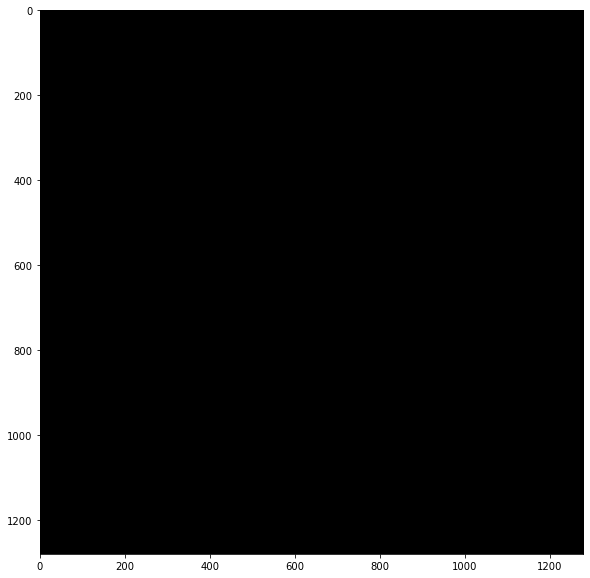

In [455]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# img = cv2.imread(impat)
# new_imag = img.copy()
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (900,100,650,540)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imshow("grey", img)
# cv2.waitKey(0)
plt.rcParams['figure.figsize'] = (20, 10)
plt.imshow(img)
# plt.colorbar()
plt.show()

In [ ]:
def grab_cut_mask(img_col, mask, debug=False):
    assert isinstance(img_col, numpy.ndarray), 'image must be a numpy array'
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert img_col.ndim == 3, 'skin detection can only work on color images'
    assert mask.ndim == 2, 'mask must be 2D'

    kernel = numpy.ones((50, 50), numpy.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = numpy.array(cv2.bitwise_not(dst), dtype=numpy.uint8)

    if debug:
        scripts.display('not skin', free)
        scripts.display('grabcut input', mask)

    grab_mask = numpy.zeros(mask.shape, dtype=numpy.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if numpy.unique(grab_mask).tolist() == [0, 1]:
        logger.debug('conducting grabcut')
        bgdModel = numpy.zeros((1, 65), numpy.float64)
        fgdModel = numpy.zeros((1, 65), numpy.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = numpy.where((mask == 2) | (mask == 0), 0, 1).astype(numpy.uint8)
        else:
            logger.warning('img_col is empty')

    return mask

Number of Contours found = 3188


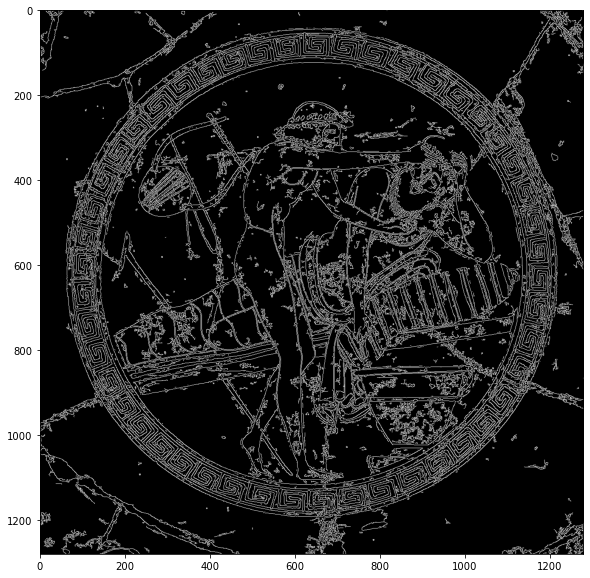

In [340]:
imgcopy = img.copy()
edged = cv2.Canny(new_imag, 30, 200)

  
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image

ret, threshold = cv2.threshold(edged, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
# cv2.imshow('Canny Edges After Contouring', edged)
# cv2.waitKey(0)
contours, hierarchy = cv2.findContours(threshold, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours)))
  
# Draw all contours
# -1 signifies drawing all contours
cv2.drawContours(edged, contours, 1, (0, 255, 0), 5)

plt.imshow(threshold, cmap='gray')

In [ ]:
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,
	fgModel, iterCount=args["iter"], mode=cv2.GC_INIT_WITH_RECT)

TypeError: Invalid shape (1280, 1280, 1280) for image data

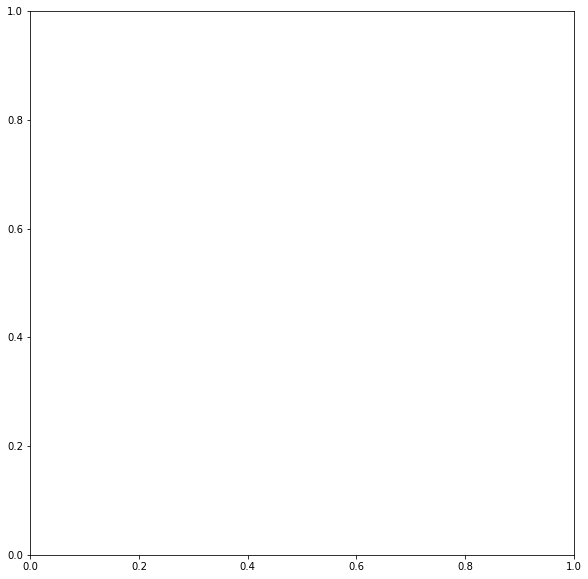

In [128]:
img = cv2.imread(impat)
edged = cv2.Canny(img, 30, 200)
img = img + edged[:,:,np.newaxis]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros(img.shape[:2],np.uint8)
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (700,400,850,500)
# cv2.grabCut(thresh,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

# mask[mask == 0] = cv2.GC_BGD
# mask[mask == 255] = cv2.GC_FGD
img = img*mask2[:,:,np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
plt.imshow(img)
plt.show()

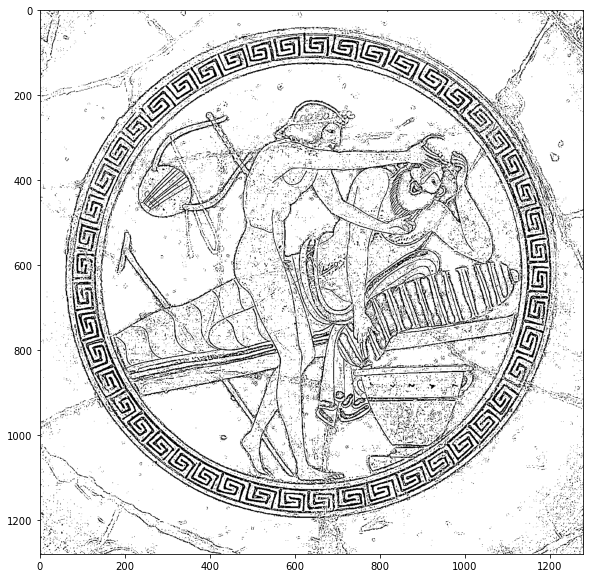

In [433]:
img = cv2.imread(impat)
edged = cv2.Canny(img, 30, 200)
img = img + edged[:,:,np.newaxis]
mask = np.zeros(img.shape[:2],np.uint8)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
######### Testing ###########
binarized_image = cv2.adaptiveThreshold(
    gray,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)

# Initialize the mask with known information
 
mask[:] = cv2.GC_PR_BGD
mask[binarized_image == 0] = cv2.GC_FGD


#################

# bgdModel = np.zeros((1,65),np.float64)
# fgdModel = np.zeros((1,65),np.float64)
# rect = (700,400,850,500)
# cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
# # mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# mask[mask == 0] = cv2.GC_BGD
# mask[mask == 255] = cv2.GC_FGD
# img = img*mask2[:,:,np.newaxis]
# plt.rcParams['figure.figsize'] = (20, 10)
plt.imshow(binarized_image, cmap='gray')
plt.show()

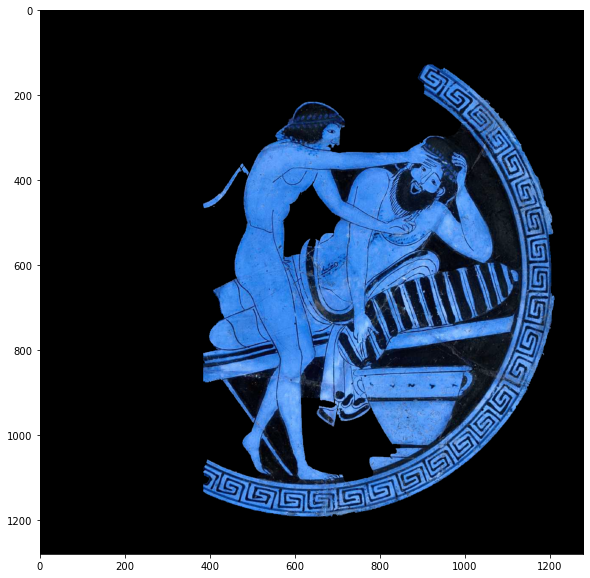

In [418]:
import cv2.cv2 as cv2
import numpy as np

# Read the original image
# IMAGES_FOLDER = "Path to your image folder"
# original_image = cv2.imread(str(IMAGES_FOLDER / "spoon.jpg"))

original_image = cv2.imread(impat)
# original_image = cv2.cvtColor(original_image, cv2.)
# Define boundary rectangle containing the foreground object
height, width, _ = original_image.shape
left_margin_proportion = 0.3
right_margin_proportion = 0.3
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

# Set the seed for reproducibility purposes
cv2.setRNGSeed(0)

# Initialize GrabCut mask image, that will store the segmentation results
mask = np.zeros((height, width), np.uint8)

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

number_of_iterations = 5

cv2.grabCut(
    img=original_image,
    mask=mask,
    rect=boundary_rectangle,
    bgdModel=background_model,
    fgdModel=foreground_model,
    iterCount=number_of_iterations,
    mode=cv2.GC_INIT_WITH_RECT,
)


grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]
plt.imshow(segmented_image)
plt.show()

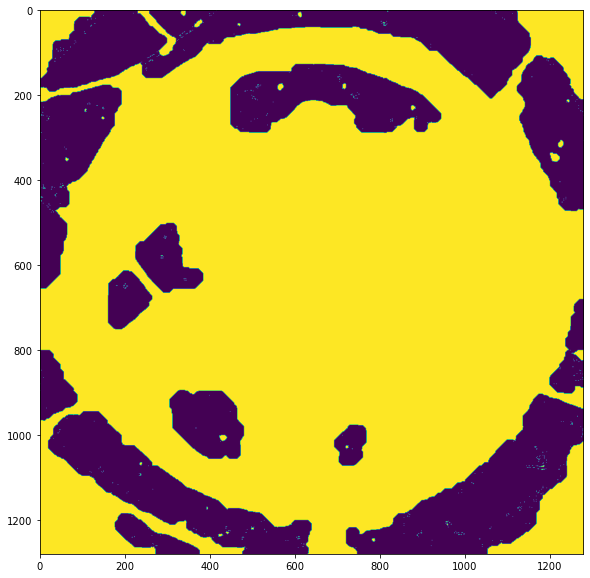

In [430]:
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
# show_image(gray_image, "Gray image")

binarized_image = cv2.adaptiveThreshold(
    gray_image,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)

# Initialize the mask with known information
mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[binarized_image == 0] = cv2.GC_FGD

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)
rect = (700,400,850,500)
cv2.grabCut(
    original_image,
    mask,
    rect,
#     boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)

plt.imshow(grabcut_mask)
plt.show()

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread(impath)
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,150,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
contour, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(img),plt.imshow(contour),plt.show()

In [ ]:
 newmask = cv2.imread('newmask.png',0)
    3 
    4 # whereever it is marked white (sure foreground), change mask=1
    5 # whereever it is marked black (sure background), change mask=0
    6 mask[newmask == 0] = 0
    7 mask[newmask == 255] = 1
    8 
    9 mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
   10 
   11 mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
   12 img = img*mask[:,:,np.newaxis]
   13 plt.imshow(img),plt.colorbar(),plt.show()
